# Determing the price of cars

A used car service is developing an app to attract new customers.
In it, you can quickly find out the market price of your car.
We have historical data: technical specifications, configurations and prices of cars. We need to build a model to determine the value.

Important for the customer:

- quality of prediction;
- prediction speed;
- studying time.

 The key steps of our project will be:

* Loading and preparing data
* Training different models. Hyperparameter adjustment
* Analysis of the speed of the models and their quality
  
The project is made in **Jupyter Notebook**, Notebook server version: 6.1.4. Version **Python** 3.7.8.
Libraries used in the project:
* **Pandas**
* **NumPy**
* **scikit-learn**
* **MatPlotLib**
* **Seaborne**
* **Light GBM**
* **IPython**
* **re**
* **time**

## Loading and preparing the data

In [1]:
pip install seaborn==0.11.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import all the required libraries and modules.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import re
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the data.
data = pd.read_csv('autos.csv')
# Describe the data.
data.info()
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
# Create a column_renamer function that allows
# change the case of the letters of the column names and
# separate words with underscores.
def column_renamer(data):
    new_names_list = []
    for column in data.columns:
        # Write a regular expression.
        name = re.sub('(?!^)([A-Z]+)', r'_\1', column).lower()
        new_names_list.append(name)
    return new_names_list

data.columns = column_renamer(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [4]:
# Columns date_crawled, registration_month,
# last_seen will not be useful to us for training the model.
# Remove them.
data = data.drop(
    ['date_crawled', 'registration_month', 'last_seen'], 
    axis=1
)
# The number_of_pictures column seems to be all zeros.
# If so, we don't need it.
display(data['number_of_pictures'].value_counts())
# Let's get rid of it.
data = data.drop(['number_of_pictures'], axis=1)
data.info()

0    354369
Name: number_of_pictures, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   not_repaired       283215 non-null  object
 10  date_created       354369 non-null  object
 11  postal_code        354369 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 32.4+ MB


In [5]:
# Convert the date_created column to datetime format.
data['date_created'] = pd.to_datetime(
    data['date_created'], 
    format='%Y.%m.%d'
)
# Select the month.
data['date_created'] = pd.DatetimeIndex(data['date_created']).month
# It makes sense to rename the column.
data.rename(columns={'date_created':'month_created'}, inplace=True)
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,3,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,3,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,3,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3,60437
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes,3,2694
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,3,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,3,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,3,87439


In [6]:
# Create a function to examine the data.
sns.set_theme(style='whitegrid')
def explore(data, column, bins):
    sns.displot(
        data[column],
        kind='hist',
        bins=bins, 
        height=6, 
        aspect=13.5/6, 
        kde=True
    )
    plt.xlabel('Number')
    plt.ylabel('Value')
    plt.title('Histogram of distribution of values of ' + str(column) + ' parameter')
    plt.figure(figsize=(17,3))
    sns.boxplot(data[column])
    plt.xlabel('Value')
    plt.title('Boxplot for the ' + str(column) + ' parameter')
    plt.show()
    display(data[column].describe())
    display(data[column].value_counts())

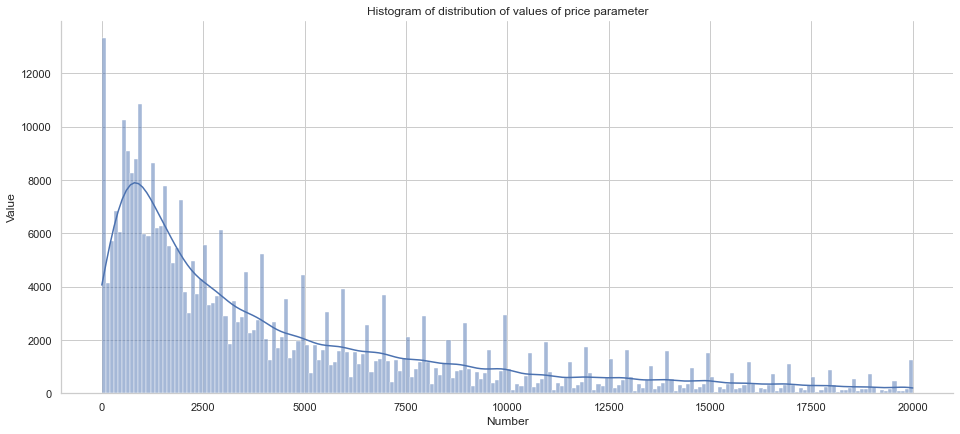

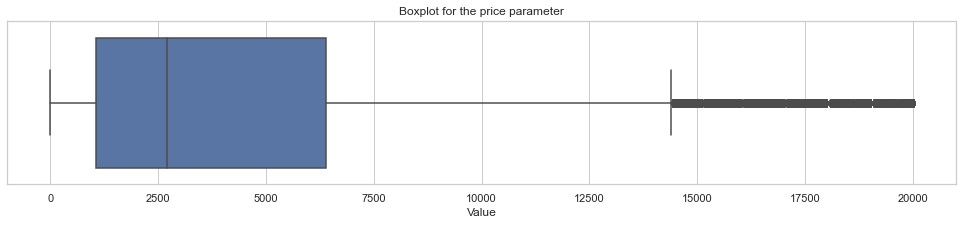

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [7]:
explore(data, 'price', 200)

In [8]:
# Look at the table for zero values in the price column.
display(data.query('price == 0'))
# You can't replace zeros correctly.
# Get rid of rows with zeros in this column so as not to
# confuse model.
data = data.loc[data['price'] != 0].reset_index(drop=True)
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,3,19348
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN,3,56412
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN,3,21698
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN,3,37520
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes,3,27432
...,...,...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes,3,23758
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN,3,33659
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN,3,42329
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,3,22559


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,3,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,3,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,3,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3,60437
...,...,...,...,...,...,...,...,...,...,...,...,...
343592,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,3,26624
343593,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,3,39576
343594,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,3,26135
343595,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,3,87439


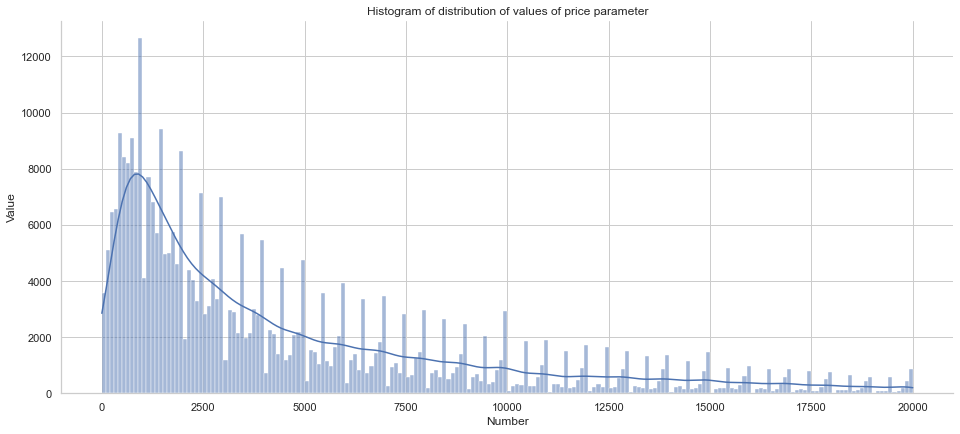

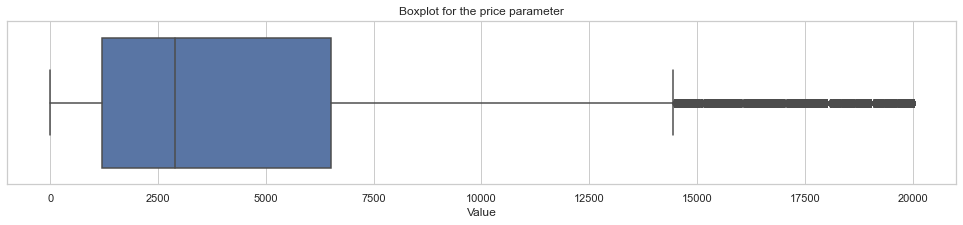

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

500      5670
1500     5394
1000     4649
1200     4594
2500     4438
         ... 
7435        1
16845       1
17159       1
7396        1
10985       1
Name: price, Length: 3730, dtype: int64

In [9]:
# Let's look at the data distribution now.
explore(data, 'price', 200)

A suspicious price was found - 1 euro. Let's check the prices. Analyzed data from websites
auto.ru and avito.ru, we come to the conclusion that
cars do not sell for less than 30,000 rubles or 390 euros
at the rate of 2016.

In [10]:
# We will display only prices from 1 to 390 euros.
display(data.query('1 <= price <= 390'))
# Get rid of lines with prices less than 390 euros.
data = data.loc[data['price'] > 390].reset_index(drop=True)
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
15,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN,4,38871
31,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no,3,44145
34,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no,3,19386
57,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN,3,53721
58,200,coupe,1995,manual,102,3er,150000,petrol,bmw,NaN,3,23560
...,...,...,...,...,...,...,...,...,...,...,...,...
343503,150,small,1993,manual,55,astra,150000,petrol,opel,yes,3,66424
343538,99,small,1999,manual,60,arosa,150000,petrol,seat,yes,3,91301
343558,350,small,1996,NaN,65,punto,150000,NaN,fiat,NaN,3,25436
343564,390,small,1997,auto,0,corsa,100000,petrol,opel,yes,4,17509


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,3,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,3,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,3,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3,60437
...,...,...,...,...,...,...,...,...,...,...,...,...
324886,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,3,26624
324887,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,3,39576
324888,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,3,26135
324889,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,3,87439


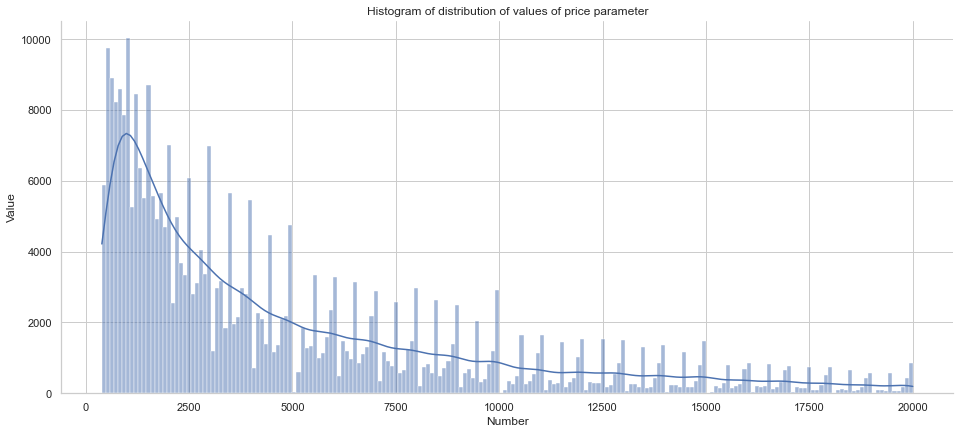

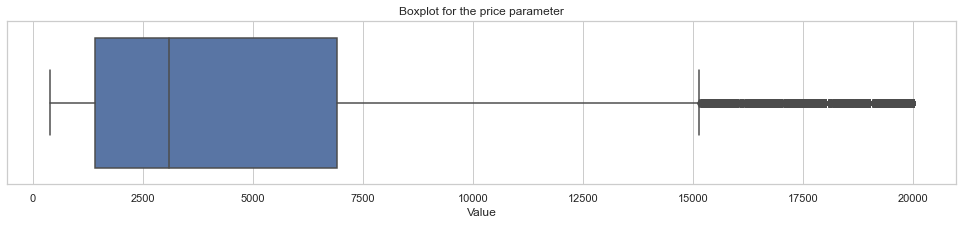

count    324891.000000
mean       4804.789671
std        4518.170210
min         393.000000
25%        1400.000000
50%        3099.000000
75%        6900.000000
max       20000.000000
Name: price, dtype: float64

500      5670
1500     5394
1000     4649
1200     4594
2500     4438
         ... 
7595        1
17449       1
6435        1
10009       1
10985       1
Name: price, Length: 3514, dtype: int64

In [11]:
# Let's look at the data distribution now.
explore(data, 'price', 200)

In [12]:
# Now examine the vehicle_type column.
# Examine missing values.
display(data.loc[data['vehicle_type'] != data['vehicle_type']])
# Now let's see what models are presented.
display(data['model'].value_counts())
# Most often we see golf, other, 3er, polo, corsa.
# Let's see what types of car body are found.
models = ['golf', 'other', '3er', 'polo', 'corsa']
for model, i in zip(models, range(13,18)):
    print('Body types of the', model, 'model')
    display(data.loc[data['model'] == model].head(20))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,3,70435
20,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no,3,49716
24,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no,3,31139
29,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN,3,37075
33,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no,3,46483
...,...,...,...,...,...,...,...,...,...,...,...,...
324860,3299,NaN,2005,auto,0,outlander,150000,petrol,mitsubishi,NaN,3,17034
324869,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN,3,61169
324874,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no,3,87700
324884,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no,3,51371


golf                  26761
other                 22441
3er                   18684
polo                  11106
corsa                 10380
                      ...  
samara                    6
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

Body types of the golf model


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,3,70435
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,91074
8,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN,3,27472
43,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN,3,48499
53,1000,sedan,1998,manual,101,golf,150000,petrol,volkswagen,no,3,39624
67,6600,sedan,2006,manual,105,golf,150000,gasoline,volkswagen,no,3,41812
70,800,NaN,2000,manual,90,golf,150000,gasoline,volkswagen,NaN,3,32584
98,6300,sedan,2002,manual,265,golf,150000,petrol,volkswagen,no,3,56759
108,1000,sedan,1990,manual,54,golf,150000,petrol,volkswagen,no,3,47447
110,8000,NaN,2009,manual,0,golf,100000,petrol,volkswagen,no,3,94139


Body types of the other model


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
22,500,sedan,1990,manual,118,other,150000,petrol,mercedes_benz,yes,3,35390
34,11900,other,2002,manual,129,other,150000,gasoline,volkswagen,no,4,10551
35,1500,bus,1984,manual,70,other,150000,gasoline,mercedes_benz,no,3,22767
47,1400,NaN,2016,manual,55,other,5000,NaN,hyundai,NaN,4,34454
52,2399,NaN,2018,manual,64,other,125000,NaN,seat,no,3,33397
60,2100,suv,2000,manual,105,other,150000,petrol,honda,no,2,85244
61,1280,sedan,1992,auto,109,other,150000,petrol,mercedes_benz,NaN,3,86163
76,1800,bus,2001,manual,87,other,150000,gasoline,mitsubishi,no,3,24116
80,1222,sedan,1984,auto,180,other,150000,petrol,opel,NaN,4,57290
99,3500,coupe,1991,manual,160,other,150000,petrol,volkswagen,no,4,66111


Body types of the 3er model


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,4,33775
30,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no,3,39179
48,7999,sedan,2008,auto,143,3er,150000,gasoline,bmw,NaN,3,71083
57,14999,convertible,2007,manual,218,3er,50000,petrol,bmw,no,3,1129
91,650,sedan,1997,auto,102,3er,150000,petrol,bmw,NaN,3,13357
100,5950,sedan,2006,manual,163,3er,150000,gasoline,bmw,yes,3,63526
113,3390,NaN,2000,NaN,0,3er,150000,NaN,bmw,NaN,3,45739
126,4200,wagon,2003,auto,204,3er,150000,gasoline,bmw,no,4,53757
147,2900,coupe,2000,auto,170,3er,150000,petrol,bmw,no,3,53332
155,2999,wagon,2001,manual,0,3er,150000,petrol,bmw,NaN,3,45891


Body types of the polo model


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
63,800,small,1993,manual,0,polo,150000,petrol,volkswagen,no,3,8258
104,9290,small,2010,manual,86,polo,40000,petrol,volkswagen,no,3,35630
158,5999,small,2009,manual,80,polo,125000,petrol,volkswagen,no,3,65529
219,950,small,1995,manual,54,polo,150000,petrol,volkswagen,no,3,34270
223,11919,small,2012,auto,90,polo,30000,petrol,volkswagen,no,3,6110
251,9500,sedan,2012,manual,69,polo,50000,petrol,volkswagen,NaN,3,91722
346,2950,small,2004,manual,54,polo,90000,petrol,volkswagen,NaN,3,41812
416,4490,small,2008,manual,60,polo,100000,petrol,volkswagen,no,3,1993
467,500,small,1996,manual,45,polo,150000,petrol,volkswagen,no,3,19303
601,2100,small,2005,manual,64,polo,150000,petrol,volkswagen,no,3,84307


Body types of the corsa model


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
198,900,NaN,2017,manual,60,corsa,150000,petrol,opel,no,3,33602
222,500,small,1999,manual,56,corsa,150000,petrol,opel,no,3,32756
249,590,sedan,1996,manual,0,corsa,150000,NaN,opel,NaN,3,32052
311,500,small,1996,manual,45,corsa,70000,petrol,opel,NaN,4,8496
318,9999,small,2014,manual,90,corsa,20000,petrol,opel,no,3,55294
347,400,NaN,2017,manual,65,corsa,150000,petrol,opel,yes,4,56479
358,500,small,1995,manual,45,corsa,150000,petrol,opel,no,3,85748
362,650,small,1997,manual,45,corsa,150000,petrol,opel,no,3,48683
364,444,small,1995,manual,45,corsa,150000,petrol,opel,no,3,58452
384,1690,small,2001,manual,75,corsa,150000,petrol,opel,no,4,63263


In [13]:
# According to tables above, we see that models can have
# a variety of bodies. Let's remove the gaps.
data = data.dropna(subset=['vehicle_type']).reset_index(drop=True)
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
0,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,3,66954
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,3,90480
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,91074
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3,60437
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,4,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
296372,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,3,96465
296373,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,3,26624
296374,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,3,26135
296375,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,3,87439


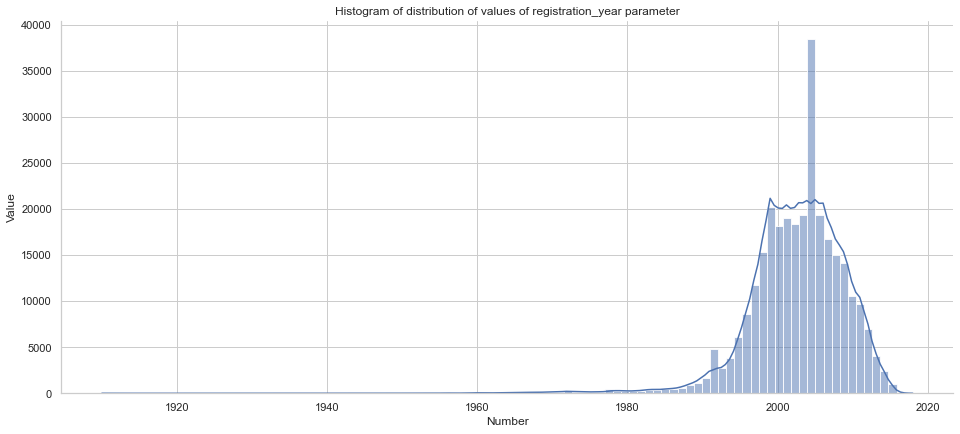

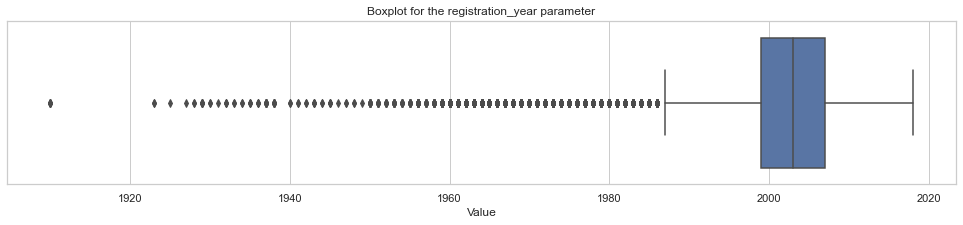

count    296377.000000
mean       2002.577646
std           6.454517
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: registration_year, dtype: float64

1999    20236
2006    19329
2003    19304
2005    19282
2004    19197
        ...  
1925        1
1931        1
1949        1
1927        1
1946        1
Name: registration_year, Length: 94, dtype: int64

In [14]:
# Examine the registration year column.
explore(data, 'registration_year', 100)

In [15]:
# There are suspiciously many cars in the registration_year column
# registered before 1960. Let's consider them.
before_1960 = data.query('registration_year < 1960')
display(before_1960)
# Exmaine the models.
display(before_1960['model'].value_counts())
# Store the model names in a separate list.
# Models of the Other group will not be saved in the list.
# Let's look at them separately later.
old_models = before_1960['model'].value_counts().index[1:]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
13,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN,3,24148
1589,7000,suv,1945,manual,48,other,150000,petrol,volkswagen,no,3,58135
1872,1800,convertible,1925,NaN,0,NaN,5000,NaN,sonstige_autos,no,3,79288
2756,10500,sedan,1955,manual,30,other,60000,petrol,ford,NaN,3,53498
10787,11000,other,1955,manual,40,NaN,50000,petrol,sonstige_autos,no,3,59556
...,...,...,...,...,...,...,...,...,...,...,...,...
291794,11000,suv,1950,manual,0,other,5000,petrol,chevrolet,no,4,79098
293694,17500,sedan,1954,manual,52,other,20000,petrol,citroen,no,3,55270
293786,5500,bus,1956,manual,37,NaN,60000,petrol,sonstige_autos,no,3,1900
295664,6000,sedan,1937,manual,38,other,5000,petrol,mercedes_benz,NaN,3,23936


other       120
kaefer        6
500           4
c3            2
kadett        2
ka            1
passat        1
agila         1
astra         1
beetle        1
2_reihe       1
b_klasse      1
espace        1
Name: model, dtype: int64

We have a list of models, and we can find the release years of these models on the Internet. So we will find out where the correct data on the year of registration and incorrect ones are indicated.

In [16]:
# First, let's look at the other model group.
# Select it in a separate slice.
other = before_1960.loc[data['model'] == 'other']
# And now let's see the historical data on the creation
# brands data from the table.
display(other[['registration_year', 'brand']].
        sort_values(
            by=['registration_year'], ascending=True
        ).head(60))

,registration_year,brand
250773,1927,ford
149864,1928,citroen
196834,1928,ford
281103,1929,bmw
114967,1929,bmw
192256,1929,bmw
102859,1930,peugeot
256233,1930,ford
220378,1931,ford
209929,1932,peugeot


In [17]:
# Data is the same as historical data.
# Consider now the rest of the models.
old_models_data = before_1960.loc[before_1960['model'].isin(old_models)]
display(old_models_data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
13,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN,3,24148
19752,3900,wagon,1910,manual,90,passat,150000,petrol,volkswagen,NaN,3,88662
30883,7500,small,1954,manual,16,500,125000,petrol,fiat,no,3,82327
32431,18500,sedan,1959,manual,30,kaefer,70000,petrol,volkswagen,no,3,84034
40821,600,small,1910,manual,0,agila,5000,NaN,opel,yes,3,61279
43650,500,small,1945,manual,1000,astra,100000,NaN,opel,yes,3,1723
52465,3400,small,1910,manual,90,beetle,90000,NaN,volkswagen,no,3,34308
90685,14000,sedan,1936,NaN,0,500,5000,NaN,fiat,no,3,90518
98247,8750,convertible,1923,manual,11,c3,5000,petrol,citroen,no,3,27299
104400,8500,small,1952,manual,0,500,5000,petrol,fiat,no,3,85045


Using the wikipedia article, we analyzed model registration data and identified ads with unrealistic registration years. For example, the Volkswagen Passat could not have been registered in 1910, and the Ford Ka in 1910.

In [18]:
# Delete lines 13, 19752, 40821, 43650, 52465, 187129, 270983.
data = data.drop([13, 19752, 40821, 43650, 52465, 187129, 270983])

In [19]:
# Reexamine the registration_year column, given
# NaN values in the model column.
nan_models = data.loc[data['model'] != data['model']]
# Let's make a cut of cars before 1960.
nan_models_before_1960 = nan_models.loc[
    nan_models['registration_year'] < 1960]
display(nan_models_before_1960[['registration_year', 'brand', 
                                'vehicle_type', 'gearbox', 'power']].
        sort_values(
            by=['registration_year'], ascending=True
        ).head(60))

,registration_year,brand,vehicle_type,gearbox,power
98176,1910,renault,small,manual,0
1872,1925,sonstige_autos,convertible,NaN,0
198843,1929,sonstige_autos,sedan,NaN,0
109746,1929,sonstige_autos,sedan,NaN,0
18828,1929,sonstige_autos,sedan,manual,30
204318,1934,sonstige_autos,other,NaN,0
87755,1935,sonstige_autos,sedan,manual,25
247386,1937,sonstige_autos,coupe,manual,150
94787,1937,sonstige_autos,sedan,manual,0
65667,1937,sonstige_autos,sedan,NaN,0


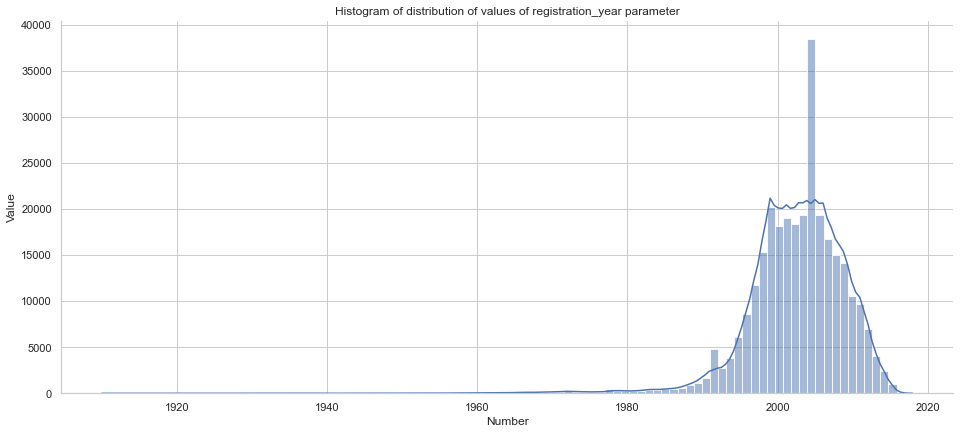

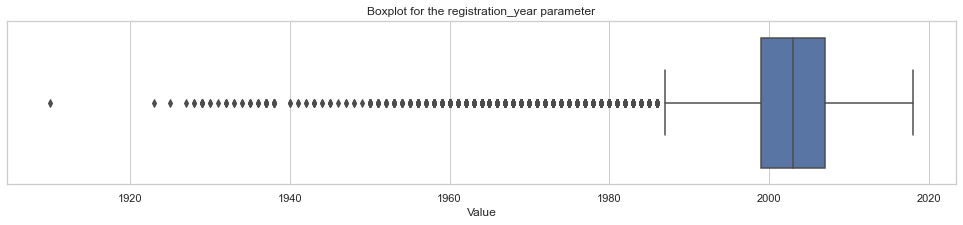

count    296370.000000
mean       2002.579671
std           6.440856
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: registration_year, dtype: float64

1999    20236
2006    19329
2003    19304
2005    19282
2004    19197
        ...  
1949        1
1925        1
1931        1
1927        1
1946        1
Name: registration_year, Length: 94, dtype: int64

In [20]:
# Examine the registration_year column after our changes.
explore(data, 'registration_year', 100)

In [21]:
# Data is historical. Let's update the indexes.
data = data.reset_index(drop=True)
# Data is historical. Let's update the indexes. 
nan_gearbox = data.loc[data['gearbox'] != data['gearbox']]
# Change NaN to manual in the gearbox column for cars
# older than 1946. After checking several sources, we are convinced that
# in serial production of cars with automatic transmission launched in 1946
# Prior to that, these were piece copies.
data.loc[
    (data['gearbox'] != data['gearbox']) &
    (data['registration_year'] < 1946),['gearbox']
] = data.loc[
    (data['gearbox'] != data['gearbox']) & 
    (data['registration_year'] < 1946),['gearbox']
].fillna('manual')
# Now remove the NaN values from the dataset for this column.
# It will not be possible to replace them correctly, and there is no point in specifying unknown.
# We have a fairly large sample, and after the release of our application
# filling in the type of gearbox will be a mandatory item in the advertisement form.
data = data.dropna(subset=['gearbox']).reset_index(drop=True)

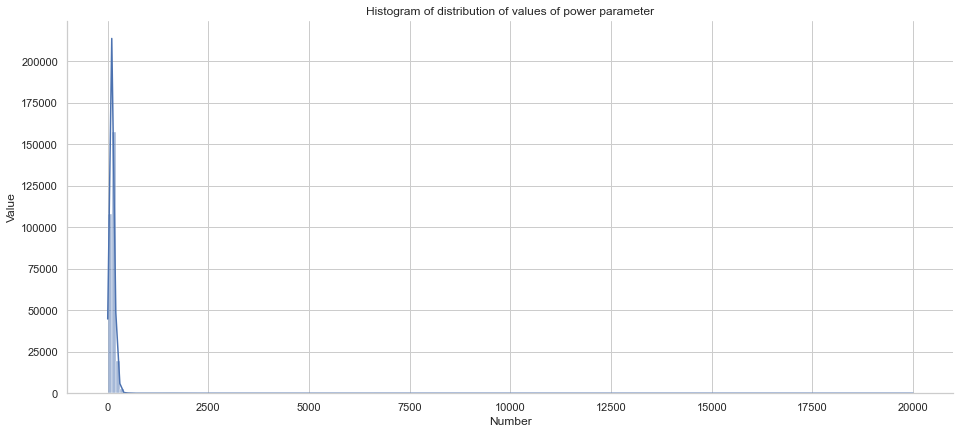

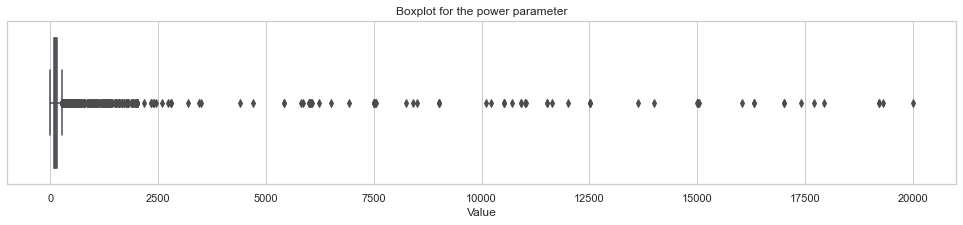

count    288078.000000
mean        119.273478
std         185.605407
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

75      18975
0       16411
150     12995
60      12014
140     11849
        ...  
487         1
519         1
2461        1
6006        1
1548        1
Name: power, Length: 642, dtype: int64

In [22]:
# Examine the power column.
explore(data, 'power', 200)

In [23]:
# Engine power as of 2016
# cannot be higher than 1479 hp
# Also power cannot be zero.
# Get rid of lines with invalid values.
data = data.loc[
    (data['power'] > 0) & 
    (data['power'] < 1479)].reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271522 entries, 0 to 271521
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              271522 non-null  int64 
 1   vehicle_type       271522 non-null  object
 2   registration_year  271522 non-null  int64 
 3   gearbox            271522 non-null  object
 4   power              271522 non-null  int64 
 5   model              263044 non-null  object
 6   kilometer          271522 non-null  int64 
 7   fuel_type          262428 non-null  object
 8   brand              271522 non-null  object
 9   not_repaired       238614 non-null  object
 10  month_created      271522 non-null  int64 
 11  postal_code        271522 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 24.9+ MB


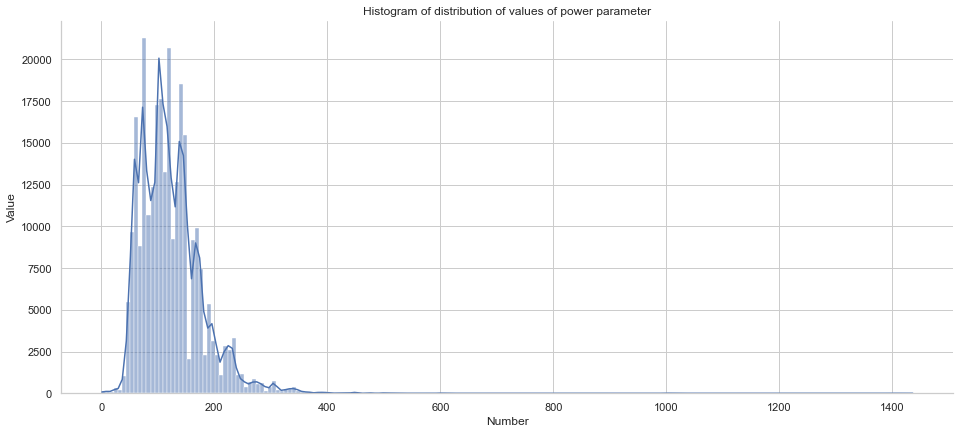

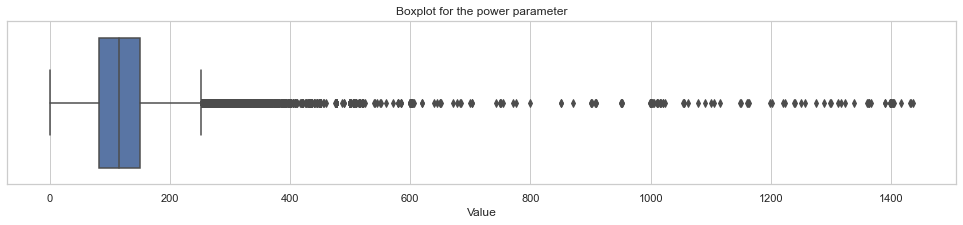

count    271522.000000
mean        123.423177
std          57.467634
min           1.000000
25%          82.000000
50%         116.000000
75%         150.000000
max        1436.000000
Name: power, dtype: float64

75      18975
150     12995
60      12014
140     11849
101     11419
        ...  
602         1
1339        1
851         1
1054        1
1004        1
Name: power, Length: 520, dtype: int64

In [24]:
# Now take a look at this column.
explore(data, 'power', 200)

In [25]:
# Examine the model column.
pd.set_option("max_rows", None)
display(data['model'].value_counts())
# We can replace NaN values in this column
# with the word other.
data['model'] = data['model'].fillna('other')

golf                  22140
other                 19000
3er                   16564
polo                   9191
a4                     8514
corsa                  8431
passat                 8359
astra                  8141
c_klasse               7109
5er                    6938
e_klasse               5785
a3                     4890
a6                     4830
focus                  4727
2_reihe                4134
fiesta                 4067
transporter            3934
1er                    3191
a_klasse               3139
twingo                 3115
fortwo                 3101
vectra                 3022
touran                 2785
3_reihe                2726
mondeo                 2640
clio                   2531
zafira                 2380
punto                  2223
megane                 2150
ibiza                  2114
lupo                   1972
octavia                1880
fabia                  1830
cooper                 1781
ka                     1646
clk                 

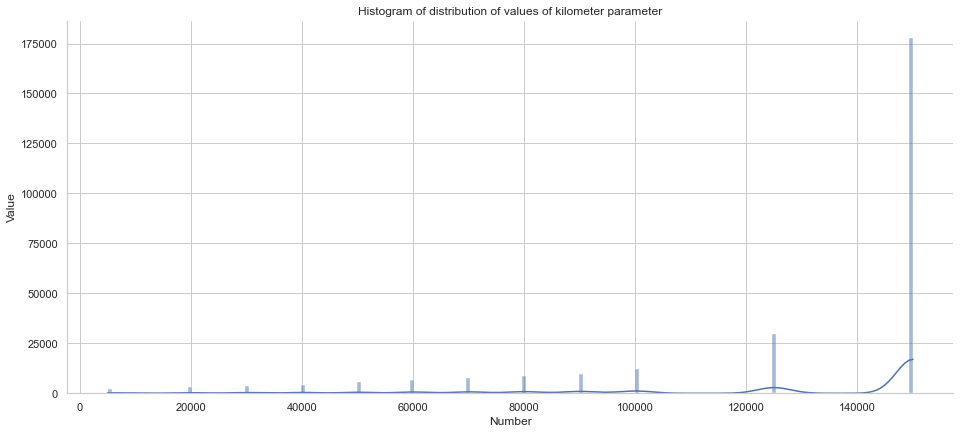

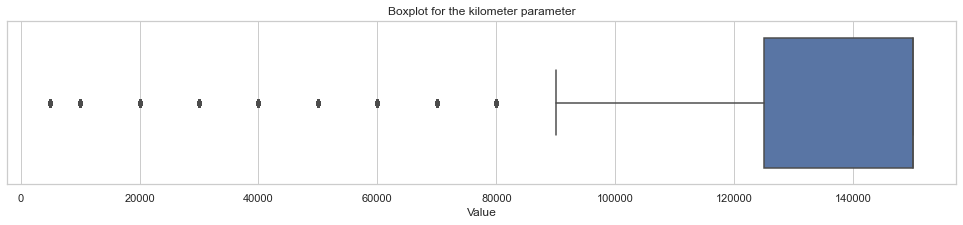

count    271522.000000
mean     127744.050206
std       36882.490909
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

150000    177525
125000     29766
100000     12072
90000       9778
80000       8599
70000       7498
60000       6599
50000       5461
40000       4360
30000       3725
20000       3038
5000        2218
10000        883
Name: kilometer, dtype: int64

In [26]:
# Examine the kilometer column.
explore(data, 'kilometer', 200)

In [27]:
# Just remove the missing values in the kilometer column.
data = data.dropna(subset=['kilometer'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271522 entries, 0 to 271521
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              271522 non-null  int64 
 1   vehicle_type       271522 non-null  object
 2   registration_year  271522 non-null  int64 
 3   gearbox            271522 non-null  object
 4   power              271522 non-null  int64 
 5   model              271522 non-null  object
 6   kilometer          271522 non-null  int64 
 7   fuel_type          262428 non-null  object
 8   brand              271522 non-null  object
 9   not_repaired       238614 non-null  object
 10  month_created      271522 non-null  int64 
 11  postal_code        271522 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 26.9+ MB


In [28]:
# Examine the fuel_type column.
display(data['fuel_type'].value_counts())
# Replace NaN-values with other.
data['fuel_type'] = data['fuel_type'].fillna('other')
data.info()

petrol      172008
gasoline     85147
lpg           4478
cng            454
hybrid         196
other           77
electric        68
Name: fuel_type, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271522 entries, 0 to 271521
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              271522 non-null  int64 
 1   vehicle_type       271522 non-null  object
 2   registration_year  271522 non-null  int64 
 3   gearbox            271522 non-null  object
 4   power              271522 non-null  int64 
 5   model              271522 non-null  object
 6   kilometer          271522 non-null  int64 
 7   fuel_type          271522 non-null  object
 8   brand              271522 non-null  object
 9   not_repaired       238614 non-null  object
 10  month_created      271522 non-null  int64 
 11  postal_code        271522 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 26.9+ MB


In [29]:
# Examine the brand column.
display(data['brand'].value_counts())
# For convenience, replace the German sonstige_autos
# into English other.
data['brand'] = data['brand'].replace(to_replace='sonstige_autos', value='other')

volkswagen        58082
bmw               30823
opel              28413
mercedes_benz     26259
audi              24365
ford              18122
renault           12259
peugeot            8641
fiat               6685
seat               5308
skoda              4766
mazda              4343
citroen            3920
toyota             3848
smart              3694
nissan             3649
hyundai            2971
mini               2861
volvo              2658
mitsubishi         2197
honda              2176
kia                1986
alfa_romeo         1799
suzuki             1790
sonstige_autos     1688
chevrolet          1413
chrysler           1097
dacia               780
porsche             599
subaru              578
jeep                567
daihatsu            518
land_rover          456
saab                443
jaguar              429
daewoo              339
lancia              328
rover               299
trabant             220
lada                153
Name: brand, dtype: int64

In [30]:
# Examine the not_repaired column.
display(data['not_repaired'].value_counts())
# Replace NaN-values with unknown.
data['not_repaired'] = data['not_repaired'].fillna('unknown')

no     215453
yes     23161
Name: not_repaired, dtype: int64

In [31]:
pd.set_option("max_rows", 20)
# Examine the postal_code column.
display(data['postal_code'].value_counts())

10115    797
65428    464
60311    257
66333    240
52525    230
        ... 
54484      1
96197      1
95358      1
67587      1
95691      1
Name: postal_code, Length: 8087, dtype: int64

In [32]:
# Let's take another look at our data.
display(data)
display(data.info())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created,postal_code
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,3,66954
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,3,90480
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,91074
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3,60437
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,4,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
271517,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no,4,81825
271518,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,3,96465
271519,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,3,26135
271520,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,3,87439


<class 'pandas.core.frame.DataFrame'>
Int64Index: 271522 entries, 0 to 271521
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              271522 non-null  int64 
 1   vehicle_type       271522 non-null  object
 2   registration_year  271522 non-null  int64 
 3   gearbox            271522 non-null  object
 4   power              271522 non-null  int64 
 5   model              271522 non-null  object
 6   kilometer          271522 non-null  int64 
 7   fuel_type          271522 non-null  object
 8   brand              271522 non-null  object
 9   not_repaired       271522 non-null  object
 10  month_created      271522 non-null  int64 
 11  postal_code        271522 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 26.9+ MB


None

### Conclusion. Data preprocessing

Let's sum up the data preprocessing
1. Loaded and explored data.
2. Changed column names: words are separated by underscores, all letters are lowercase.
3. Removed columns that cannot or practically do not affect the meaning of pricing: *date_crawled*, *registration_month*, *last_seen*.
4. The data format in the *date_created* column is converted to `DateTime`. Of the entire date, only a month was left - according to the meaning of the model, only a month can be useful. Column name changed to *month_created*.
5. Created `explore` function for statistical data analysis using **Seaborn** library
6. Removed zero values in the *price* column. Dropped lines with prices less than 390 euros. Preliminarily analyzed ads for the sale of used cars on the sites auto.ru and avito.ru: people do not sell cars for less than 390 euros (at the rate of 2016).
7. There are 8 body types in the *vehicle_type* column: sedan - sedan, small - hatchback, wagon - station wagon, bus - bus / minibus, convertible - convertible, coupe - coupe (two-door car with a separate trunk), suv - SUVs, other — other types of bodies. It is not possible to correctly replace `NaN`-values in this column. Lines with `NaN`-values have been removed.
8. Column *registration_year* studied. Incorrect data on the years of registration of cars that do not correspond to historical data have been identified. Rows with such data have been removed. Also removed are `NaN`-values that cannot be replaced correctly.
9. Part of the missing values in the gearbox column (before 1946) was replaced by manual, as the most likely option, given the information from sources on the Internet, saying that the first serial automatic transmission was released in 1946. The remaining lines with `NaN`-values have been removed.
10. Removed `NaN` values in the power column with a power equal to 0, as well as values greater than 1479 hp. (maximum as of 2016 according to wikipedia).
11. In the *model* column, `NaN`-values are replaced with other.
12. Removed missing values in the *kilometer* column.
13. In the *fuel_type* column, `NaN`-values have been replaced with *other*.
14. In the *brand* column, the German sonstige_autos values were replaced with the English other.
15. `NaN`-values in the *not_repaired* column are replaced by unknown.

In [33]:
# The dataset contains both quantitative,
# and categorical features. Let's use technology
# direct encoding OHE.
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe)
display(data_ohe.info())

,price,registration_year,power,kilometer,month_created,postal_code,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
0,18300,2011,190,125000,3,66954,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,3,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75,150000,3,91074,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69,90000,3,60437,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,4,33775,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271517,3999,2005,3,150000,4,81825,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271518,3200,2004,225,150000,3,96465,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
271519,1199,2000,101,125000,3,26135,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
271520,9200,1996,102,150000,3,87439,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 271522 entries, 0 to 271521
Columns: 309 entries, price to not_repaired_yes
dtypes: int64(6), uint8(303)
memory usage: 93.0 MB


None

In [34]:
# Denote the target and other features.
features = data_ohe.drop(['price'], axis=1)
target = data_ohe['price']
# Set sizes are.
print('Features set size is ', features.shape)
print('Target set size is ', target.shape)

Features set size is  (271522, 308)
Target set size is  (271522,)


In [35]:
# Prepare training and test sets.
# Test set size 0.25.
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target, 
    test_size=.25,
    random_state=12345
)
# Check set sizes.
kits = ['features_train', 'features_test', 
        'target_train', 'target_test']
for kit in kits:
    print(str(kit) + ' set size is', eval(kit).shape)

features_train set size is (203641, 308)
features_test set size is (67881, 308)
target_train set size is (203641,)
target_test set size is (67881,)


### Conclusion. Data preparation.

The data were prepared for building models.
We processed the dataset using direct encoding technique. They broke it down into target and other signs. We divided them into training and test sets.
Let's move on to model training.

## Training different models

In [36]:
# Let's make an rmse scorer for cross-validation.
def rmse (answers, predictions):
    predictions = np.array(predictions)
    answers = np.array(answers)
    score = np.sqrt(((predictions - answers) ** 2).mean())
    return score
my_scorer = make_scorer(rmse, greater_is_better=False)

### Linear Regression

In [37]:
# Let's start with a linear regression model.
model_lr = LinearRegression()

In [38]:
%%time
# Calculate the RMSE metric for the linear regression model.
# For the sake of curiosity, we will measure the time required for
# cross-validation of all models.
scores = abs(cross_val_score(
    model_lr, 
    features, 
    target, 
    scoring=my_scorer, 
    cv=5
    ))
final_score = scores.mean()
print('The best RMSE of a linear regression model is', final_score)
lr_score = final_score

The best RMSE of a linear regression model is 2623.8608918150017
CPU times: user 49.4 s, sys: 3.81 s, total: 53.2 s
Wall time: 31.5 s


In [39]:
%%time
# Measure the training time of the linear regression model.
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 8.09 s, sys: 541 ms, total: 8.63 s
Wall time: 4.89 s


LinearRegression()

### Gradient Boosting model

In [40]:
%%time
# Create a gradient boosting model.
# using the Light GBM library.
model_gb = lgb.LGBMRegressor(boosting_type='gbdt', random_state=12345)
param_grid = {
    'num_leaves': [13, 25], 
    'max_depth': [5, 7]
}
# Adjust hyperparameters.
grid_cv_gb = GridSearchCV(estimator=model_gb, 
                          param_grid=param_grid, 
                          scoring=my_scorer,
                          cv=5,
                          n_jobs=-1)
grid_cv_gb.fit(features_train, target_train)

CPU times: user 5.7 s, sys: 683 ms, total: 6.39 s
Wall time: 40.9 s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'num_leaves': [13, 25]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [41]:
# The best model parameters are:
best_parameters = grid_cv_gb.best_params_
print('Best parameters are:\n', best_parameters)

Best parameters are:
 {'max_depth': 7, 'num_leaves': 25}


In [42]:
# Best RMSE is:
best_cv_gb_score = abs(grid_cv_gb.best_score_)
print('Best gradient boosting model RMSE is', best_cv_gb_score)

Best gradient boosting model RMSE is 1682.1563759496264


In [43]:
%%time
# Measure the training time of the gradient boosting model.
model_gb = lgb.LGBMRegressor(boosting_type='gbdt',
                             num_leaves=25,
                             max_depth=7,
                             random_state=12345)
model_gb.fit(features_train, target_train)

CPU times: user 5.45 s, sys: 438 ms, total: 5.89 s
Wall time: 2.3 s


LGBMRegressor(max_depth=7, num_leaves=25, random_state=12345)

### Decision Tree model

In [44]:
%%time
# Create a decision tree model.
model_dt = DecisionTreeRegressor(random_state=12345)
parameters_set = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [6, 8, 12] 
}
# Adjust the hyperparameters.
grid_cv_dt = GridSearchCV(estimator=model_dt,
                      param_grid=parameters_set,
                      scoring=my_scorer,
                      cv=5,
                      n_jobs=-1)
grid_cv_dt.fit(features_train, target_train)

CPU times: user 4.03 s, sys: 736 ms, total: 4.76 s
Wall time: 4min 4s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [6, 8, 12]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [45]:
# The best model parameters are:
best_parameters = grid_cv_dt.best_params_
print('Best parameters are:\n', best_parameters)

Best parameters are:
 {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}


In [46]:
# Best RMSE is:
best_cv_dt_score = abs(grid_cv_dt.best_score_)
print('Best decision tree model RMSE is', best_cv_dt_score)

Best decision tree model RMSE is 2243.997547364385


In [47]:
%%time
# Measure the training time of the decision tree model.
model_dt = DecisionTreeRegressor(max_depth=6,
                                 min_samples_leaf=2,
                                 min_samples_split=6,
                                 random_state=12345)
model_dt.fit(features_train, target_train)

CPU times: user 2.8 s, sys: 253 ms, total: 3.05 s
Wall time: 3.1 s


DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, min_samples_split=6,
                      random_state=12345)

### Random Forest model

In [48]:
%%time
# Create a random forest model.
model_rf = RandomForestRegressor(random_state=12345)
parameters_set = {
    'max_depth': [3, 4, 5],
    'n_estimators': [10, 20, 30]
}
# Adjust the hyperparameters.
grid_cv_rf = GridSearchCV(estimator=model_rf,
                      param_grid=parameters_set,
                      scoring=my_scorer,
                      cv=5,
                      n_jobs=-1)
grid_cv_rf.fit(features_train, target_train)

CPU times: user 44.8 s, sys: 598 ms, total: 45.4 s
Wall time: 9min 17s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'n_estimators': [10, 20, 30]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [49]:
# Best parameters are:
best_parameters = grid_cv_rf.best_params_
print('Best parameters are:\n', best_parameters)

Best parameters are:
 {'max_depth': 5, 'n_estimators': 30}


In [50]:
# Best RMSE is.
best_cv_rf_score = abs(grid_cv_rf.best_score_)
print('Best random forest model RMSE is', best_cv_rf_score)

Best random forest model RMSE is 2328.2586776004896


In [51]:
%%time
# Measure the training time of the random forest model.
model_rf = RandomForestRegressor(max_depth=5,
                                 n_estimators=30,
                                 random_state=12345)
model_rf.fit(features_train, target_train)

CPU times: user 43.8 s, sys: 359 ms, total: 44.2 s
Wall time: 44.5 s


RandomForestRegressor(max_depth=5, n_estimators=30, random_state=12345)

### Conclusion

We have created four models:
* Linear regression model
* Gradient boosting model
* Decision tree model
* Random forest model

We also selected the most appropriate hyperparameters using cross-validation. The RMSE values based on the results of cross-validation were:

In [52]:
# Prepare a table with the results of the RMSE evaluation.
rmse_results = pd.DataFrame(
    {'RMSE after cross-validation':[lr_score, best_cv_gb_score, 
             best_cv_dt_score, best_cv_rf_score]}, 
    index=[
        'Linear Regression', 
        'Gradient Boosting', 
        'Decision Tree', 
        'Random Forest'
    ]
)
rmse_results.index.name = 'Model'
display(rmse_results)

,RMSE after cross-validation
Model,
Linear Regression,2623.860892
Gradient Boosting,1682.156376
Decision Tree,2243.997547
Random Forest,2328.258678


Time spent on cross-validation and training

In [53]:
# Prepare a table with measurement results
# time.
cv_fit_time = pd.DataFrame(
    {'Time spent for cross-validation': 
     ['00:00:31','00:00:41', '00:04:04', '00:09:17'], 
    'Time spent for training': 
     ['00:00:05', '00:00:02', '00:00:03', '00:00:45'],
    'Total time': ['00:00:36', '00:00:43', '00:04:07', '00:10:02']}, 
    index=[
        'Linear Regression', 
        'Gradient Boosting', 
        'Decision Tree', 
        'Random Forest'
    ])
display(cv_fit_time)

,Time spent for cross-validation,Time spent for training,Total time
Linear Regression,00:00:31,00:00:05,00:00:36
Gradient Boosting,00:00:41,00:00:02,00:00:43
Decision Tree,00:04:04,00:00:03,00:04:07
Random Forest,00:09:17,00:00:45,00:10:02


At this stage of the study, we found that the largest amount of time is spent on cross-validation of the random forest model - 9 minutes 17 seconds. The smallest is a linear regression (31 seconds).
Gradient boosting is trained the fastest - 2 seconds. The longest is random forest (45 seconds). Linear regression is trained in 5 seconds, decision tree - 3 seconds.

The best indicator of the RMSE metric according to the results of cross-validation was shown by the gradient boosting model - 1682 euros. The worst is linear regression (2624 euros).
Let's move on to the analysis of models, their testing.

## Model analysis

### Linear Regression

In [54]:
# Create model and train it.
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

In [55]:
%%time
# Make predictions.
predictions_lr = pd.Series(
    model_lr.predict(features_test), 
    index=target_test.index
    )

CPU times: user 189 ms, sys: 132 ms, total: 321 ms
Wall time: 288 ms


In [56]:
rmse_lr = (mean_squared_error(target_test, predictions_lr))**0.5
print('RMSE is', rmse_lr)

RMSE is  2623.0391569379017


### Gradient Boosting

In [57]:
# Create model and train it.
model_gb = lgb.LGBMRegressor(boosting_type='gbdt',
                             num_leaves=25,
                             max_depth=7,
                             random_state=12345)
model_gb.fit(features_train, target_train)

LGBMRegressor(max_depth=7, num_leaves=25, random_state=12345)

In [58]:
%%time
# Make predictions.
predictions_gb = pd.Series(
    model_gb.predict(features_test), 
    index=target_test.index
    )

CPU times: user 1.07 s, sys: 130 ms, total: 1.2 s
Wall time: 537 ms


In [59]:
rmse_gb = (mean_squared_error(target_test, predictions_gb))**0.5
print('RMSE is', rmse_gb)

RMSE is 1684.291111487341


### Decision Tree

In [60]:
# Create model and train it.
model_dt = DecisionTreeRegressor(max_depth=6,
                                 min_samples_leaf=2,
                                 min_samples_split=6,
                                 random_state=12345)
model_dt.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, min_samples_split=6,
                      random_state=12345)

In [61]:
%%time
# Make predicitons.
predictions_dt = pd.Series(
    model_dt.predict(features_test), 
    index=target_test.index
    )

CPU times: user 89.6 ms, sys: 63.3 ms, total: 153 ms
Wall time: 152 ms


In [62]:
rmse_dt = (mean_squared_error(target_test, predictions_dt))**0.5
print('RMSE is', rmse_dt)

RMSE is 2246.008540303359


### Random forest

In [63]:
# Create model and train it.
model_rf = RandomForestRegressor(max_depth=5,
                                 n_estimators=30,
                                 random_state=12345)
model_rf.fit(features_train, target_train)

RandomForestRegressor(max_depth=5, n_estimators=30, random_state=12345)

In [64]:
%%time
# Make predictions.
predictions_rf = pd.Series(
    model_rf.predict(features_test), 
    index=target_test.index
    )

CPU times: user 183 ms, sys: 72.7 ms, total: 256 ms
Wall time: 267 ms


In [65]:
rmse_rf = (mean_squared_error(target_test, predictions_rf))**0.5
print('RMSE is', rmse_rf)

RMSE is 2330.2182179791753


### Conclusion

In [66]:
# Prepare a table with the results of the RMSE.
rmse_results_test = pd.DataFrame(
    {'RMSE on test set':[rmse_lr, rmse_gb, 
             rmse_dt, rmse_rf]}, 
    index=[
        'Linear Regression', 
        'Gradient Boosting', 
        'Decision Tree', 
        'Random Forest'
    ]
)
rmse_results_test.index.name = 'Model'
display(rmse_results_test)

,RMSE on test set
Model,
Linear Regression,2623.039157
Gradient Boosting,1684.291111
Decision Tree,2246.008540
Random Forest,2330.218218


In [67]:
# Подготовим таблицу с результатами оценки
# времени, затраченного на предсказания.
prediction_time = pd.DataFrame(
    {'Time spent for predictions': 
     ['00:00:0.288','00:00:0.537', '00:00:0.152', '00:00:0.267']}, 
    index=[
        'Linear Regression', 
        'Gradient Boosting', 
        'Decision Tree', 
        'Random Forest'
    ])
display(prediction_time)

,Time spent for predictions
Linear Regression,00:00:0.288
Gradient Boosting,00:00:0.537
Decision Tree,00:00:0.152
Random Forest,00:00:0.267


In [68]:
# Prepare final table.
prediction_time = pd.DataFrame(
    {'Time spent for training':
     ['00:00:05', '00:00:02', '00:00:03', '00:00:45'],
        'Time spent for predictions': 
     ['00:00:0.288','00:00:0.537', '00:00:0.152', '00:00:0.267'],
    'Total time':
    ['00:00:05.288', '00:00:02.537','00:00:03.152', '00:00:45.267'],
    'RMSE on test set': [rmse_lr, rmse_gb, 
             rmse_dt, rmse_rf]}, 
    index=[
        'Linear Regression', 
        'Gradient Boosting', 
        'Decision Tree', 
        'Random Forest'
    ])
display(prediction_time)

,Time spent for training,Time spent for predictions,Total time,RMSE on test set
Linear Regression,00:00:05,00:00:0.288,00:00:05.288,2623.039157
Gradient Boosting,00:00:02,00:00:0.537,00:00:02.537,1684.291111
Decision Tree,00:00:03,00:00:0.152,00:00:03.152,2246.008540
Random Forest,00:00:45,00:00:0.267,00:00:45.267,2330.218218


## General conclusion

After analyzing the results, we can offer the customer a gradient boosting model.
The gradient boosting model is the fastest at 2 seconds and 537 milliseconds. The RMSE indicator is 1684 euros - this is the best indicator of the four.